In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io

class ParabolicWanPDESolver(nn.Module):
    def __init__(self, dim, N_dm, N_bd, file_path, beta_int, beta_intw, beta_bd,
                 v_step, v_rate, u_step, u_rate, u_layer=6, u_neuron=40,
                 iteration=20001, device='cuda'):
        super(ParabolicWanPDESolver, self).__init__()

        self.device = device
        self.low, self.up = -1.0, 1.0  # Пространственные границы
        self.t0, self.t1 = 0.0, 1.0    # Временные границы
        self.dim = dim                  # Пространственная размерность (без времени!)
        self.mesh_size = 50
        self.dm_size = N_dm
        self.bd_size = N_bd
        self.iteration = iteration
        self.dir = file_path
        self.beta_int = beta_int
        self.beta_intw = beta_intw
        self.beta_bd = beta_bd

        # Параметры для точного решения
        self.la = np.pi / 2
        self.pho = 2.0
        self.mu = self.la**2 - 1

        self.v_layer = 6
        self.v_h_size = 40
        self.v_step = v_step
        self.v_rate = v_rate

        self.u_layer = u_layer
        self.u_h_size = u_neuron
        self.u_step = u_step
        self.u_rate = u_rate

        # ИНТЕРФЕЙС НЕ МЕНЯЛСЯ: сети принимают (dim+1) входов
        self.net_u = NetU(dim + 1, 1, u_layer, u_neuron).to(device)
        self.net_v = NetV(dim + 1, 1, self.v_layer, self.v_h_size).to(device)

        self.optimizer_u = torch.optim.Adam(self.net_u.parameters(), lr=u_rate)
        self.optimizer_v = torch.optim.Adagrad(self.net_v.parameters(), lr=v_rate)

    def sample_train(self, dm_size, bd_size, dim):
        low, up, t0, t1 = self.low, self.up, self.t0, self.t1

        # 1. Точки внутри области: [x, t]
        x_dm = np.random.uniform(low, up, [dm_size, dim])          # Пространство
        t_dm = np.random.uniform(t0, t1, [dm_size, 1])             # Время
        x_dm_full = np.concatenate([x_dm, t_dm], axis=1)           # [x, t]

        # f(x,t) = μu - u² для точного решения u = ρ·sin(λx₁)·exp((μ-λ²)t)
        u_exact = self.pho * np.sin(self.la * x_dm[:, 0:1]) * np.exp((self.mu - self.la**2) * t_dm)
        f_dm = self.mu * u_exact - u_exact**2
        f_dm = np.reshape(f_dm, [-1, 1])

        # 2. Начальные условия (t = t0)
        x_init = np.random.uniform(low, up, [bd_size, dim])
        t_init = t0 * np.ones([bd_size, 1])
        x_init_full = np.concatenate([x_init, t_init], axis=1)
        u_init = self.pho * np.sin(self.la * x_init[:, 0:1]) * np.exp((self.mu - self.la**2) * t_init)
        u_init = np.reshape(u_init, [-1, 1])

        # 3. Конечное время (t = t1) - нужно для слабой формы
        x_right = np.random.uniform(low, up, [bd_size, dim])
        t_right = t1 * np.ones([bd_size, 1])
        x_right_full = np.concatenate([x_right, t_right], axis=1)

        # 4. Пространственные границы в разные моменты времени
        x_bd_list = []
        for i in range(dim):
            # Граница при x_i = up
            x_bound = np.random.uniform(low, up, [bd_size, dim])
            t_bound = np.random.uniform(t0, t1, [bd_size, 1])
            x_bound[:, i] = up
            x_bd_list.append(np.concatenate([x_bound, t_bound], axis=1))

            # Граница при x_i = low
            x_bound = np.random.uniform(low, up, [bd_size, dim])
            t_bound = np.random.uniform(t0, t1, [bd_size, 1])
            x_bound[:, i] = low
            x_bd_list.append(np.concatenate([x_bound, t_bound], axis=1))

        x_bd = np.concatenate(x_bd_list, axis=0)
        u_bd = self.pho * np.sin(self.la * x_bd[:, 0:1]) * np.exp((self.mu - self.la**2) * x_bd[:, -1:])
        u_bd = np.reshape(u_bd, [-1, 1])

        # Собираем всё в тензоры
        train_dict = {}
        train_dict['x_dm'] = torch.FloatTensor(x_dm_full).to(self.device)    # [x,t]
        train_dict['x_init'] = torch.FloatTensor(x_init_full).to(self.device)
        train_dict['x_right'] = torch.FloatTensor(x_right_full).to(self.device)
        train_dict['x_bd'] = torch.FloatTensor(x_bd).to(self.device)
        train_dict['f_val'] = torch.FloatTensor(f_dm).to(self.device)
        train_dict['u_init'] = torch.FloatTensor(u_init).to(self.device)
        train_dict['u_bd'] = torch.FloatTensor(u_bd).to(self.device)

        return train_dict

    def sample_test(self, mesh_size, dim):
        low, up, t0, t1 = self.low, self.up, self.t0, self.t1

        x_mesh = np.linspace(low, up, mesh_size)
        t_mesh = np.linspace(t0, t1, mesh_size)
        mesh = np.meshgrid(x_mesh, t_mesh)

        # Тестовые точки: [x, t]
        x_test = np.random.uniform(low, up, [mesh_size*mesh_size, dim])
        t_test = np.random.uniform(t0, t1, [mesh_size*mesh_size, 1])
        x_test_full = np.concatenate([x_test, t_test], axis=1)

        # Точное решение
        u_exact = self.pho * np.sin(self.la * x_test[:, 0:1]) * np.exp((self.mu - self.la**2) * t_test)
        u_exact = np.reshape(u_exact, [-1, 1])

        test_dict = {}
        test_dict['mesh'] = mesh
        test_dict['test_x'] = torch.FloatTensor(x_test_full).to(self.device)  # [x,t]
        test_dict['test_u'] = torch.FloatTensor(u_exact).to(self.device)

        return test_dict

    # ВЕСОВАЯ ФУНКЦИЯ ОСТАЁТСЯ ПРЕЖНЕЙ (только по пространству!)
    def fun_w(self, x, low, up):
        I1 = 0.210987
        # x содержит только пространственные координаты (без времени!)
        x_list = torch.split(x, 1, dim=1)

        x_scale_list = []
        h_len = (up - low) / 2.0
        for i in range(self.dim):  # self.dim = пространственная размерность
            x_scale = (x_list[i] - low - h_len) / h_len
            x_scale_list.append(x_scale)

        z_x_list = []
        for i in range(self.dim):
            supp_x = (1 - torch.abs(x_scale_list[i])) > 0
            z_x = torch.where(supp_x,
                             torch.exp(1/(torch.pow(x_scale_list[i], 2)-1))/I1,
                             torch.zeros_like(x_scale_list[i]))
            z_x_list.append(z_x)

        w_val = torch.ones_like(x_list[0])
        for i in range(self.dim):
            w_val = torch.mul(w_val, z_x_list[i])

        w_val.requires_grad_(True)
        dw = torch.autograd.grad(w_val, x,
                                grad_outputs=torch.ones_like(w_val),
                                create_graph=True, retain_graph=True)[0]
        dw = torch.where(torch.isnan(dw), torch.zeros_like(dw), dw)
        return w_val, dw

    # ГРАДИЕНТЫ: теперь по всем координатам (x,t)
    def grad_u(self, x_in):
        x_in.requires_grad_(True)
        u_val = self.net_u(x_in)  # x_in: [batch, dim+1]
        grad_u = torch.autograd.grad(u_val, x_in,
                                   grad_outputs=torch.ones_like(u_val),
                                   create_graph=True, retain_graph=True)[0]
        return u_val, grad_u

    def grad_v(self, x_in):
        x_in.requires_grad_(True)
        v_val = self.net_v(x_in)
        grad_v = torch.autograd.grad(v_val, x_in,
                                   grad_outputs=torch.ones_like(v_val),
                                   create_graph=True, retain_graph=True)[0]
        return v_val, grad_v

    # ГЛАВНОЕ ИЗМЕНЕНИЕ: слабая форма для параболического уравнения
    def compute_loss(self, train_dict):
        x_dm = train_dict['x_dm']        # [x,t] внутри области
        x_init = train_dict['x_init']    # [x,t0] начальные точки
        x_right = train_dict['x_right']  # [x,t1] конечные точки
        x_bd = train_dict['x_bd']        # [x,t] на границе
        f_val = train_dict['f_val']
        u_init = train_dict['u_init']
        u_bd = train_dict['u_bd']

        # 1. Вычисляем внутри области
        u_val, grad_u = self.grad_u(x_dm)        # u, ∇u (∇ по всем координатам)
        v_val, grad_v = self.grad_v(x_dm)

        # Разделяем пространственные и временные производные
        grad_u_x = grad_u[:, :-1]  # Пространственные производные
        grad_u_t = grad_u[:, -1:]  # Производная по времени

        grad_v_x = grad_v[:, :-1]
        grad_v_t = grad_v[:, -1:]

        # Весовая функция (только по пространству!)
        w_val, grad_w = self.fun_w(x_dm[:, :-1], self.low, self.up)

        # w·v и w
        wv_val = torch.mul(w_val, v_val)

        # ∇u·∇w и ∇u·∇v (только пространственные!)
        dudw_val = torch.sum(torch.mul(grad_u_x, grad_w), dim=1, keepdim=True)
        dudv_val = torch.sum(torch.mul(grad_u_x, grad_v_x), dim=1, keepdim=True)

        # ∇u·∇(wv) = v·(∇u·∇w) + w·(∇u·∇v)
        dudwv_val = torch.add(torch.mul(v_val, dudw_val),
                            torch.mul(w_val, dudv_val))

        # u·w·∂v/∂t
        u_w_dvt_val = torch.mul(torch.mul(u_val, w_val), grad_v_t)

        # u²·w·v и f·w·v
        uu_wv_val = torch.mul(torch.mul(u_val, u_val), wv_val)
        f_wv_val = torch.mul(f_val, wv_val)

        # 2. Начальные и конечные условия
        u_init_pred, _ = self.grad_u(x_init)
        u_right_pred, _ = self.grad_u(x_right)

        w_init, _ = self.fun_w(x_init[:, :-1], self.low, self.up)
        w_right, _ = self.fun_w(x_right[:, :-1], self.low, self.up)

        v_init, _ = self.grad_v(x_init)
        v_right, _ = self.grad_v(x_right)

        # w·v при t=t0 и t=t1
        wv_init = torch.mul(w_init, v_init)
        wv_right = torch.mul(w_right, v_right)

        # u·w·v при t=t0 и t=t1
        uwv_init = torch.mul(torch.mul(u_init_pred, w_init), v_init)
        uwv_right = torch.mul(torch.mul(u_right_pred, w_right), v_right)

        # 3. Граничные условия
        u_bd_pred, _ = self.grad_u(x_bd)

        # 4. Нормы
        test_norm = torch.mean(wv_val**2)
        w_norm = torch.mean(w_val**2)

        # 5. СЛАБАЯ ФОРМА (ключевое изменение!)
        # ∫(u·w·v)|_{t=t1} + ∫∫[∇u·∇(wv) - u·w·∂v/∂t]dxdt
        # - ∫(u·w·v)|_{t=t0} - ∫∫[u²·w·v + f·w·v]dxdt = 0

        term1 = torch.mean(uwv_right)     # ∫(u·w·v)|_{t=t1}
        term2 = torch.mean(dudwv_val)     # ∫∫∇u·∇(wv)dxdt
        term3 = torch.mean(u_w_dvt_val)   # ∫∫u·w·∂v/∂t dxdt

        term4 = torch.mean(uwv_init)      # ∫(u·w·v)|_{t=t0}
        term5 = torch.mean(uu_wv_val)     # ∫∫u²·w·v dxdt
        term6 = torch.mean(f_wv_val)      # ∫∫f·w·v dxdt

        # Главный функционал
        point_dist = (term1 + term2 - term3) - (term4 + term5 + term6)
        loss_int = self.beta_int * torch.square(point_dist) / test_norm

        # Вспомогательный функционал (без v)
        uw_right = torch.mul(u_right_pred, w_right)
        uw_init = torch.mul(u_init_pred, w_init)
        uu_w_val = torch.mul(torch.mul(u_val, u_val), w_val)
        f_w_val = torch.mul(f_val, w_val)

        point_dist_w = (torch.mean(uw_right) + torch.mean(dudw_val)) - \
                      (torch.mean(uw_init) + torch.mean(uu_w_val) + torch.mean(f_w_val))
        loss_intw = self.beta_intw * torch.square(point_dist_w) / w_norm

        # Граничные и начальные условия
        loss_bd = torch.mean(torch.abs(u_bd_pred - u_bd))
        loss_init = torch.mean(torch.abs(u_init_pred - u_init))

        # Итоговый loss
        loss_u = self.beta_bd * (loss_bd + loss_init) + loss_int + loss_intw
        loss_v = -torch.log(loss_int + 1e-8)  # Адверсариальная часть

        return loss_u, loss_v, loss_int, loss_bd, loss_init, u_val, v_val

    # ОСТАЛЬНЫЕ МЕТОДЫ (main_fun и т.д.) ОСТАЮТСЯ ПРЕЖНИМИ
    def main_fun(self):
        test_dict = self.sample_test(self.mesh_size, self.dim)

        list_dict = {}
        step_list = []; err_l2r_list = []; err_l1_list = []; train_loss_list = []
        sample_time = []; train_time = []; integral_time = []

        for i in range(self.iteration):
            sample_time0 = time.time()
            train_dict = self.sample_train(self.dm_size, self.bd_size, self.dim)
            sample_time.append(time.time() - sample_time0)

            if i % 5 == 0:
                with torch.no_grad():
                    pred_u = self.net_u(test_dict['test_x'])

                test_u_np = test_dict['test_u'].cpu().numpy()
                pred_u_np = pred_u.cpu().numpy()

                err_l2 = np.sqrt(np.mean(np.square(test_u_np - pred_u_np)))
                u_l2 = np.sqrt(np.mean(np.square(test_u_np)))
                err_l2r_list.append(err_l2 / u_l2)

                err_l1 = np.mean(np.abs(test_u_np - pred_u_np))
                err_l1_list.append(err_l1)

                step_list.append(i + 1)

                loss_u, loss_v, loss_int, loss_bd, loss_init, _, _ = self.compute_loss(train_dict)
                train_loss_list.append(loss_u.item())

                if i % 500 == 0:
                    print('Iterations: {}'.format(i))
                    print('loss_u: {:.6f} loss_v: {:.6f} loss_int: {:.6f} loss_bd: {:.6f} loss_init: {:.6f} l2r: {:.6f}'.format(
                        loss_u.item(), loss_v.item(), loss_int.item(), loss_bd.item(), loss_init.item(), err_l2r_list[-1]))

            integral_time0 = time.time()
            loss_u, loss_v, loss_int, loss_bd, loss_init, _, _ = self.compute_loss(train_dict)
            integral_time.append(time.time() - integral_time0)

            train_time0 = time.time()

            # Адверсариальное обучение
            for _ in range(self.v_step):
                self.optimizer_v.zero_grad()
                loss_u, loss_v, _, _, _, _, _ = self.compute_loss(train_dict)
                loss_v.backward()
                self.optimizer_v.step()

            for _ in range(self.u_step):
                self.optimizer_u.zero_grad()
                loss_u, loss_v, _, _, _, _, _ = self.compute_loss(train_dict)
                loss_u.backward()
                self.optimizer_u.step()

            train_time.append(time.time() - train_time0)

        print('Running time is: {:.2f}'.format(sum(train_time) + sum(sample_time)))

        list_dict['err_l2r_list'] = err_l2r_list
        list_dict['err_l1_list'] = err_l1_list
        list_dict['train_loss_list'] = train_loss_list
        list_dict['step_list'] = step_list
        list_dict['sample_time'] = sample_time
        list_dict['train_time'] = train_time
        list_dict['integral_time'] = integral_time

        with torch.no_grad():
            pred_u = self.net_u(test_dict['test_x'])

        return test_dict, pred_u, list_dict, self.dim

# СЕТИ ОСТАЛИСЬ ПРЕЖНИМИ, НО ПРИНИМАЮТ dim+1 ВХОДОВ
class NetU(nn.Module):
    def __init__(self, input_dim, output_dim, layers, hidden_size):
        super(NetU, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.h_layers_a = nn.ModuleList()
        self.h_layers_b = nn.ModuleList()
        for i in range(layers):
            self.h_layers_a.append(nn.Linear(hidden_size, hidden_size))
            self.h_layers_b.append(nn.Linear(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, output_dim)
        self.activation = nn.Softplus()

    def forward(self, x):
        hi = self.activation(self.input_layer(x))
        hi_out = hi

        for i in range(self.layers):
            hi = self.activation(self.h_layers_a[i](hi_out))
            hi = torch.sin(self.h_layers_b[i](hi))
            hi_out = hi_out + hi

        out = self.output_layer(hi_out)
        return out

class NetV(nn.Module):
    def __init__(self, input_dim, output_dim, layers, hidden_size):
        super(NetV, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.h_layers = nn.ModuleList()
        for i in range(layers):
            self.h_layers.append(nn.Linear(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, output_dim)
        self.activation_tanh = nn.Tanh()
        self.activation_softplus = nn.Softplus()

    def forward(self, x):
        hi = self.activation_tanh(self.input_layer(x))

        for i in range(self.layers):
            if i % 2 == 0:
                hi = self.activation_softplus(self.h_layers[i](hi))
            else:
                hi = torch.sin(self.h_layers[i](hi))

        out = self.output_layer(hi)
        return out

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Параметры: dim = пространственная размерность (без времени!)
    layer = 2
    neuron = 40
    N_dm, N_bd = 10000, 30
    dim, iteration = 5, 20001  # dim=5 значит 5 пространственных + 1 временная = 6 входов
    print('****************layer:{} neuron:{}***************'.format(2*layer+2, neuron))

    file_path = './problem_parabolic/'
    beta_int, beta_intw, beta_bd = 100.0, 500.0, 1000.0
    v_step, v_rate, u_step, u_rate = 1, 0.015, 1, 0.001

    demo = ParabolicWanPDESolver(dim, N_dm, N_bd, file_path, beta_int, beta_intw, beta_bd,
                               v_step, v_rate, u_step, u_rate, layer, neuron, iteration, device)

    test_dict, pred_u, list_dict, dim = demo.main_fun()

    data_save = {}
    data_save['test_dict'] = {k: v.cpu().numpy() if torch.is_tensor(v) else v
                             for k, v in test_dict.items()}
    data_save['pred_u'] = pred_u.cpu().numpy() if torch.is_tensor(pred_u) else pred_u
    data_save['list_dict'] = list_dict

    scipy.io.savemat(file_path + 'wan_pde_%dd' % dim, data_save)
    print('Data saved in ' + file_path)

Using device: cuda
****************layer:6 neuron:40***************


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iterations: 0
loss_u: 2425.256348 loss_v: -0.489492 loss_int: 1.631488 loss_bd: 0.956268 loss_init: 1.456965 l2r: 1.090612
Iterations: 500
loss_u: 652.396851 loss_v: -4.400217 loss_int: 81.468544 loss_bd: 0.345067 loss_init: 0.223770 l2r: 0.383520
Iterations: 1000
loss_u: 81.013023 loss_v: 4.996797 loss_int: 0.006760 loss_bd: 0.040778 loss_init: 0.025245 l2r: 0.045510
Iterations: 1500
loss_u: 40.238911 loss_v: 1.463052 loss_int: 0.231529 loss_bd: 0.023938 loss_init: 0.015019 l2r: 0.024619
Iterations: 2000
loss_u: 36.593121 loss_v: 1.167052 loss_int: 0.311283 loss_bd: 0.019513 loss_init: 0.014721 l2r: 0.020675
Iterations: 2500
loss_u: 49.793518 loss_v: 0.372281 loss_int: 0.689161 loss_bd: 0.020656 loss_init: 0.022828 l2r: 0.023177
Iterations: 3000
loss_u: 52.712883 loss_v: -1.034443 loss_int: 2.813538 loss_bd: 0.010714 loss_init: 0.016627 l2r: 0.013011
Iterations: 3500
loss_u: 39.327801 loss_v: -1.205605 loss_int: 3.338779 loss_bd: 0.009393 loss_init: 0.008481 l2r: 0.010858
Iterations: 

FileNotFoundError: [Errno 2] No such file or directory: './problem_parabolic/wan_pde_5d.mat'

Визуализация результатов параболической задачи...


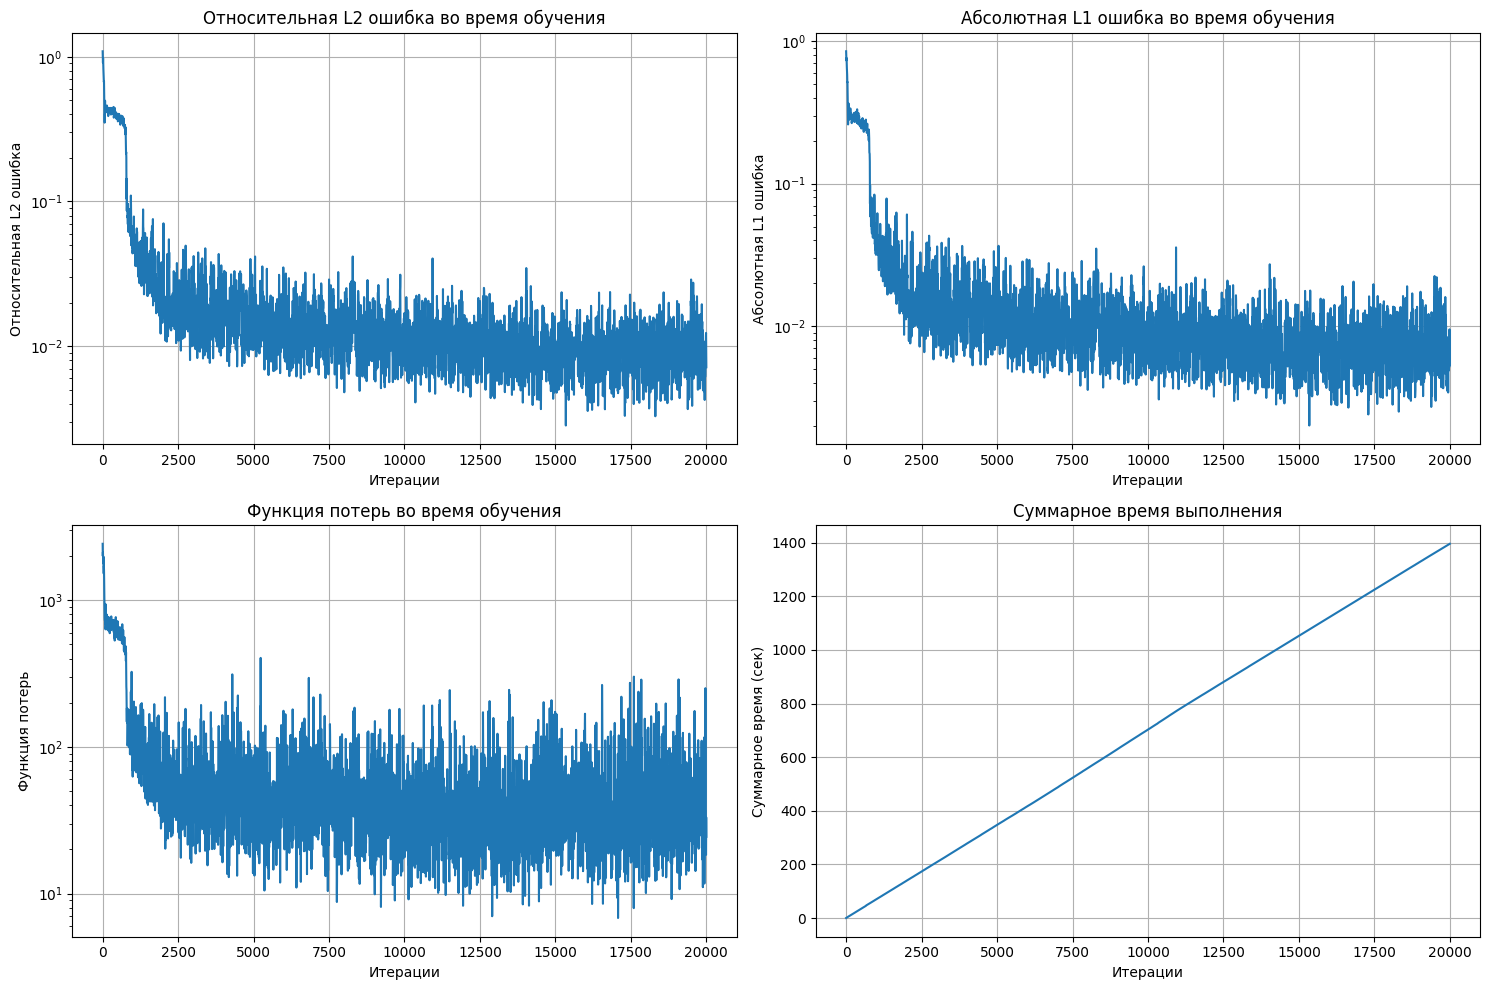

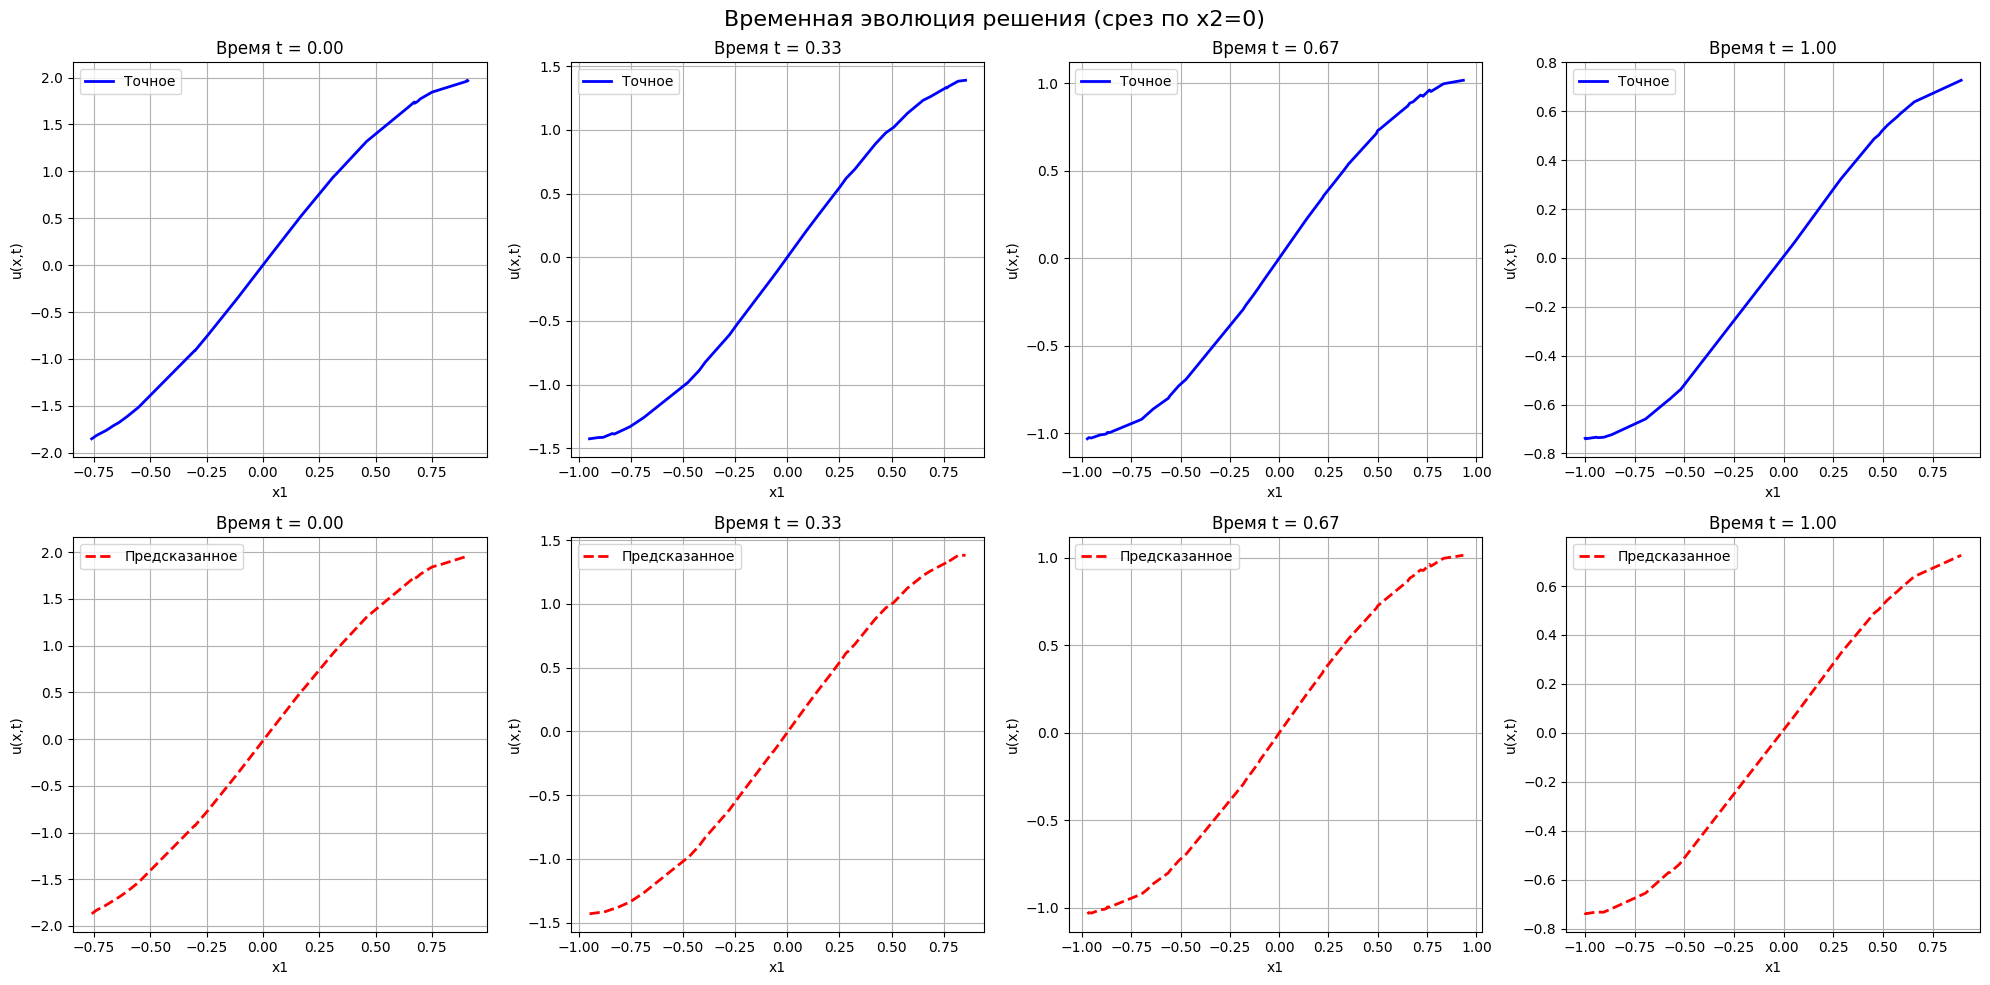

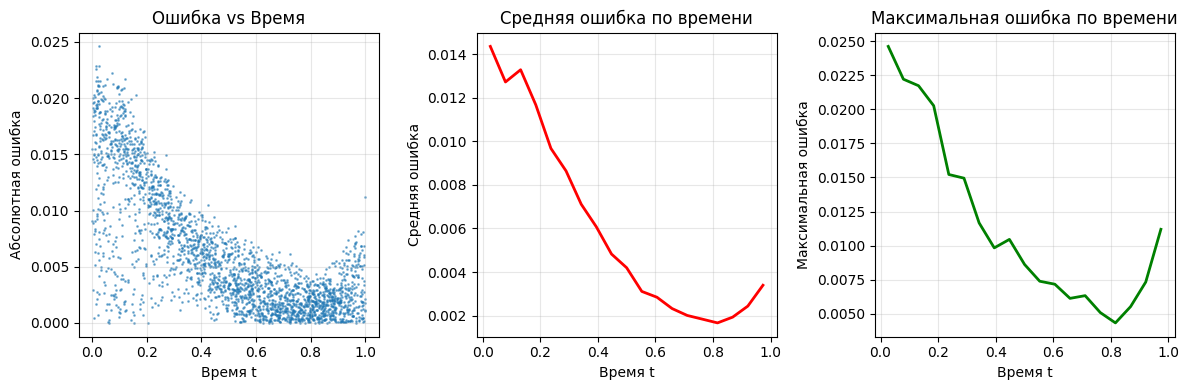

СТАТИСТИКА ОШИБОК ДЛЯ ПАРАБОЛИЧЕСКОЙ ЗАДАЧИ
Финальная относительная L2 ошибка: 0.008701
Финальная абсолютная L2 ошибка: 0.008158
Финальная абсолютная L1 ошибка: 0.006113
Максимальная абсолютная ошибка: 0.024606
Средняя ошибка при t < 0.1: 0.013717
Средняя ошибка при t > 0.9: 0.002913

ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ
Общее время выборки: 38.53 сек
Общее время обучения: 1357.44 сек
Общее время интегрирования: 372.31 сек
Общее время выполнения: 1768.27 сек
Среднее время на итерацию: 0.0884 сек


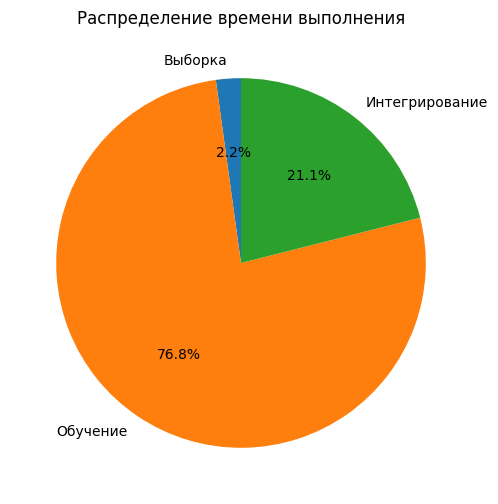


ИНФОРМАЦИЯ О ДАННЫХ
Пространственная размерность: 5
Временной интервал: [0, 1]
Количество тестовых точек: 2500
Размерность пространства+времени: 6

Доступные ключи в данных:
✓ test_dict
✓ pred_u
✓ list_dict

Ключи в test_dict: ['mesh', 'test_x', 'test_u']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

def visualize_parabolic_results(data_save, num_time_slices=5):
    """
    Визуализация результатов для параболической задачи u(x,t)

    Параметры:
    ----------
    data_save : dict
        Словарь с результатами (как в вашем коде)
    num_time_slices : int
        Количество временных срезов для визуализации
    """

    test_dict = data_save['test_dict']
    pred_u = data_save['pred_u']
    list_dict = data_save['list_dict']

    # 1. ГРАФИКИ ОШИБОК И ПОТЕРЬ (оставляем без изменений)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.semilogy(list_dict['step_list'], list_dict['err_l2r_list'])
    ax1.set_xlabel('Итерации')
    ax1.set_ylabel('Относительная L2 ошибка')
    ax1.set_title('Относительная L2 ошибка во время обучения')
    ax1.grid(True)

    ax2.semilogy(list_dict['step_list'], list_dict['err_l1_list'])
    ax2.set_xlabel('Итерации')
    ax2.set_ylabel('Абсолютная L1 ошибка')
    ax2.set_title('Абсолютная L1 ошибка во время обучения')
    ax2.grid(True)

    ax3.semilogy(list_dict['step_list'], list_dict['train_loss_list'])
    ax3.set_xlabel('Итерации')
    ax3.set_ylabel('Функция потерь')
    ax3.set_title('Функция потерь во время обучения')
    ax3.grid(True)

    iterations = len(list_dict['sample_time'])
    cumulative_time = np.cumsum(list_dict['sample_time']) + np.cumsum(list_dict['train_time'])
    ax4.plot(range(iterations), cumulative_time)
    ax4.set_xlabel('Итерации')
    ax4.set_ylabel('Суммарное время (сек)')
    ax4.set_title('Суммарное время выполнения')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    # 2. ВРЕМЕННАЯ ЭВОЛЮЦИЯ (НОВОЕ!)
    # Извлекаем данные
    test_x = test_dict['test_x']  # [x, t] координаты
    test_u = test_dict['test_u']  # точные значения

    # Разделяем пространственные координаты и время
    x_coords = test_x[:, :-1]  # пространственные координаты
    t_coords = test_x[:, -1]   # время

    # Выбираем различные моменты времени для визуализации
    time_levels = np.linspace(t_coords.min(), t_coords.max(), num_time_slices)

    fig, axes = plt.subplots(2, num_time_slices, figsize=(5*num_time_slices, 10))

    if num_time_slices == 1:
        axes = axes.reshape(2, 1)

    for i, t_val in enumerate(time_levels):
        # Выбираем точки, близкие к данному моменту времени
        time_mask = np.abs(t_coords - t_val) < 0.01

        if np.sum(time_mask) > 0:
            x_subset = x_coords[time_mask]
            u_exact_subset = test_u[time_mask]
            u_pred_subset = pred_u[time_mask]

            # Для 2D пространства показываем x1 vs u
            if x_subset.shape[1] >= 2:
                x1 = x_subset[:, 0]
                # Сортируем по x1 для гладких графиков
                sort_idx = np.argsort(x1)
                x1_sorted = x1[sort_idx]
                u_exact_sorted = u_exact_subset[sort_idx].flatten()
                u_pred_sorted = u_pred_subset[sort_idx].flatten()

                # Точное решение
                axes[0, i].plot(x1_sorted, u_exact_sorted, 'b-', linewidth=2, label='Точное')
                axes[0, i].set_title(f'Время t = {t_val:.2f}')
                axes[0, i].set_xlabel('x1')
                axes[0, i].set_ylabel('u(x,t)')
                axes[0, i].grid(True)
                axes[0, i].legend()

                # Предсказанное решение
                axes[1, i].plot(x1_sorted, u_pred_sorted, 'r--', linewidth=2, label='Предсказанное')
                axes[1, i].set_title(f'Время t = {t_val:.2f}')
                axes[1, i].set_xlabel('x1')
                axes[1, i].set_ylabel('u(x,t)')
                axes[1, i].grid(True)
                axes[1, i].legend()

    plt.suptitle('Временная эволюция решения (срез по x2=0)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. АНИМАЦИЯ ЭВОЛЮЦИИ (НОВОЕ!)
    if x_coords.shape[1] >= 2:  # Только если есть минимум 2 пространственные координаты
        # Создаем сетку для анимации
        x1_vals = np.unique(x_coords[:, 0])
        x2_vals = np.unique(x_coords[:, 1])
        t_vals = np.unique(t_coords)

        if len(x1_vals) * len(x2_vals) * len(t_vals) == len(test_x):
            # Реорганизуем данные в 3D массив
            X1, X2, T = np.meshgrid(x1_vals, x2_vals, t_vals, indexing='ij')
            U_exact_3d = test_u.reshape(len(x1_vals), len(x2_vals), len(t_vals))
            U_pred_3d = pred_u.reshape(len(x1_vals), len(x2_vals), len(t_vals))

            # Создаем анимацию
            fig = plt.figure(figsize=(12, 5))

            def update(frame):
                plt.clf()

                ax1 = fig.add_subplot(121)
                contour1 = ax1.contourf(X1[:, :, frame], X2[:, :, frame],
                                       U_exact_3d[:, :, frame], levels=50, cmap='viridis')
                ax1.set_title(f'Точное решение, t = {t_vals[frame]:.2f}')
                ax1.set_xlabel('x1')
                ax1.set_ylabel('x2')
                plt.colorbar(contour1, ax=ax1)

                ax2 = fig.add_subplot(122)
                contour2 = ax2.contourf(X1[:, :, frame], X2[:, :, frame],
                                       U_pred_3d[:, :, frame], levels=50, cmap='viridis')
                ax2.set_title(f'Предсказанное решение, t = {t_vals[frame]:.2f}')
                ax2.set_xlabel('x1')
                ax2.set_ylabel('x2')
                plt.colorbar(contour2, ax=ax2)

                plt.suptitle(f'Временная эволюция решения (кадр {frame}/{len(t_vals)-1})', fontsize=14)

                return contour1, contour2

            # Сохраняем анимацию
            try:
                ani = animation.FuncAnimation(fig, update, frames=len(t_vals),
                                            interval=200, blit=False)
                ani.save('./problem_parabolic/evolution_animation.gif', writer='pillow', fps=5)
                print("✓ Анимация сохранена как 'evolution_animation.gif'")
            except Exception as e:
                print(f"⚠ Не удалось сохранить анимацию: {e}")

            plt.tight_layout()
            plt.show()

    # 4. 3D ВИЗУАЛИЗАЦИЯ u(x1, t) при фиксированном x2
    if x_coords.shape[1] >= 1:
        # Фиксируем x2 = 0
        x2_fixed = 0
        mask = np.abs(x_coords[:, 1] - x2_fixed) < 0.1 if x_coords.shape[1] > 1 else np.ones(len(x_coords), dtype=bool)

        x1_plot = x_coords[mask, 0]
        t_plot = t_coords[mask]
        u_exact_plot = test_u[mask].flatten()
        u_pred_plot = pred_u[mask].flatten()

        # Создаем сетку для 3D поверхности
        unique_x1 = np.unique(x1_plot)
        unique_t = np.unique(t_plot)

        if len(unique_x1) * len(unique_t) == np.sum(mask):
            X1_grid, T_grid = np.meshgrid(unique_x1, unique_t, indexing='ij')
            U_exact_grid = u_exact_plot.reshape(len(unique_x1), len(unique_t))
            U_pred_grid = u_pred_plot.reshape(len(unique_x1), len(unique_t))
            U_error_grid = np.abs(U_exact_grid - U_pred_grid)

            fig = plt.figure(figsize=(18, 5))

            # Точное решение
            ax1 = fig.add_subplot(131, projection='3d')
            surf1 = ax1.plot_surface(X1_grid, T_grid, U_exact_grid, cmap='viridis', alpha=0.8)
            ax1.set_title('Точное решение u(x1,t)')
            ax1.set_xlabel('x1')
            ax1.set_ylabel('t')
            ax1.set_zlabel('u(x,t)')
            fig.colorbar(surf1, ax=ax1, shrink=0.5)

            # Предсказанное решение
            ax2 = fig.add_subplot(132, projection='3d')
            surf2 = ax2.plot_surface(X1_grid, T_grid, U_pred_grid, cmap='viridis', alpha=0.8)
            ax2.set_title('Предсказанное решение u(x1,t)')
            ax2.set_xlabel('x1')
            ax2.set_ylabel('t')
            ax2.set_zlabel('u(x,t)')
            fig.colorbar(surf2, ax=ax2, shrink=0.5)

            # Ошибка
            ax3 = fig.add_subplot(133, projection='3d')
            surf3 = ax3.plot_surface(X1_grid, T_grid, U_error_grid, cmap='hot', alpha=0.8)
            ax3.set_title('Абсолютная ошибка')
            ax3.set_xlabel('x1')
            ax3.set_ylabel('t')
            ax3.set_zlabel('|u - u_pred|')
            fig.colorbar(surf3, ax=ax3, shrink=0.5)

            plt.suptitle(f'Решение u(x1,t) при x2 = {x2_fixed}', fontsize=16)
            plt.tight_layout()
            plt.show()

    # 5. СТАТИСТИКА ОШИБОК ПО ВРЕМЕНИ (НОВОЕ!)
    if 'test_u' in test_dict:
        errors = np.abs(test_dict['test_u'] - pred_u).flatten()
        times = t_coords

        # Ошибка как функция времени
        plt.figure(figsize=(12, 4))

        plt.subplot(131)
        plt.scatter(times, errors, alpha=0.5, s=1)
        plt.xlabel('Время t')
        plt.ylabel('Абсолютная ошибка')
        plt.title('Ошибка vs Время')
        plt.grid(True, alpha=0.3)

        # Усредненная ошибка по временным интервалам
        plt.subplot(132)
        time_bins = np.linspace(times.min(), times.max(), 20)
        bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
        avg_errors = []
        for i in range(len(time_bins)-1):
            mask = (times >= time_bins[i]) & (times < time_bins[i+1])
            if np.sum(mask) > 0:
                avg_errors.append(np.mean(errors[mask]))
        plt.plot(bin_centers[:len(avg_errors)], avg_errors, 'r-', linewidth=2)
        plt.xlabel('Время t')
        plt.ylabel('Средняя ошибка')
        plt.title('Средняя ошибка по времени')
        plt.grid(True, alpha=0.3)

        # Максимальная ошибка по времени
        plt.subplot(133)
        max_errors = []
        for i in range(len(time_bins)-1):
            mask = (times >= time_bins[i]) & (times < time_bins[i+1])
            if np.sum(mask) > 0:
                max_errors.append(np.max(errors[mask]))
        plt.plot(bin_centers[:len(max_errors)], max_errors, 'g-', linewidth=2)
        plt.xlabel('Время t')
        plt.ylabel('Максимальная ошибка')
        plt.title('Максимальная ошибка по времени')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # 6. ВЫВОД СТАТИСТИКИ
    print("=" * 50)
    print("СТАТИСТИКА ОШИБОК ДЛЯ ПАРАБОЛИЧЕСКОЙ ЗАДАЧИ")
    print("=" * 50)

    if 'test_u' in test_dict:
        test_u = test_dict['test_u']
        final_l2_error = np.sqrt(np.mean((test_u - pred_u) ** 2))
        final_l1_error = np.mean(np.abs(test_u - pred_u))
        relative_l2_error = final_l2_error / np.sqrt(np.mean(test_u ** 2))

        print(f"Финальная относительная L2 ошибка: {relative_l2_error:.6f}")
        print(f"Финальная абсолютная L2 ошибка: {final_l2_error:.6f}")
        print(f"Финальная абсолютная L1 ошибка: {final_l1_error:.6f}")
        print(f"Максимальная абсолютная ошибка: {np.max(np.abs(test_u - pred_u)):.6f}")

        # Ошибка в начале и конце времени
        t_coords = test_dict['test_x'][:, -1]
        mask_begin = t_coords < 0.1
        mask_end = t_coords > 0.9

        if np.sum(mask_begin) > 0:
            error_begin = np.mean(np.abs(test_u[mask_begin] - pred_u[mask_begin]))
            print(f"Средняя ошибка при t < 0.1: {error_begin:.6f}")

        if np.sum(mask_end) > 0:
            error_end = np.mean(np.abs(test_u[mask_end] - pred_u[mask_end]))
            print(f"Средняя ошибка при t > 0.9: {error_end:.6f}")

    # 7. РАСПРЕДЕЛЕНИЕ ВРЕМЕНИ (оставляем без изменений)
    print("\n" + "=" * 50)
    print("ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ")
    print("=" * 50)

    total_sample_time = np.sum(list_dict['sample_time'])
    total_train_time = np.sum(list_dict['train_time'])
    total_integral_time = np.sum(list_dict['integral_time'])
    total_time = total_sample_time + total_train_time + total_integral_time

    print(f"Общее время выборки: {total_sample_time:.2f} сек")
    print(f"Общее время обучения: {total_train_time:.2f} сек")
    print(f"Общее время интегрирования: {total_integral_time:.2f} сек")
    print(f"Общее время выполнения: {total_time:.2f} сек")
    print(f"Среднее время на итерацию: {total_time/len(list_dict['sample_time']):.4f} сек")

    time_labels = ['Выборка', 'Обучение', 'Интегрирование']
    time_values = [total_sample_time, total_train_time, total_integral_time]

    plt.figure(figsize=(8, 6))
    plt.pie(time_values, labels=time_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Распределение времени выполнения')
    plt.show()

    # 8. ИНФОРМАЦИЯ О ДАННЫХ
    print("\n" + "=" * 50)
    print("ИНФОРМАЦИЯ О ДАННЫХ")
    print("=" * 50)

    if 'test_dict' in data_save and 'test_x' in data_save['test_dict']:
        test_x_shape = data_save['test_dict']['test_x'].shape
        spatial_dim = test_x_shape[1] - 1  # минус время
        print(f"Пространственная размерность: {spatial_dim}")
        print(f"Временной интервал: [0, 1]")
        print(f"Количество тестовых точек: {test_x_shape[0]}")
        print(f"Размерность пространства+времени: {test_x_shape[1]}")

    print("\nДоступные ключи в данных:")
    for key in ['test_dict', 'pred_u', 'list_dict']:
        if key in data_save:
            print(f"✓ {key}")

    if 'test_dict' in data_save:
        print(f"\nКлючи в test_dict: {list(data_save['test_dict'].keys())}")

# Использование
print("Визуализация результатов параболической задачи...")
visualize_parabolic_results(data_save, num_time_slices=4)